Исследование тарифных планов оператора сотовой связи 
===================

Необходимо проанализировать поведение пользователей двух тарифовных планов и выбрать лучший.  

Предоставлены данные 500 клиентов за 2018 год. 

### Шаг 1. Откроем файлы с данными, изучим информацию и приведем в надлежащий вид.

Для начала импортируем все необходимые для анализа библиотеки.

In [1]:
import matplotlib.pyplot as plt

from scipy import stats as st
import numpy as np

import math

from functools import reduce

import pandas as pd

#### Таблица `calls` (информация о звонках)

In [3]:
data_calls = pd.read_csv('datasets/calls.csv')
data_calls.head()

,Unnamed: 0,id,call_date,duration,user_id
0,0,1000_0,2018-07-25,0.00,1000
1,1,1000_1,2018-08-17,0.00,1000
2,2,1000_2,2018-06-11,2.85,1000
3,3,1000_3,2018-09-21,13.80,1000
4,4,1000_4,2018-12-15,5.18,1000


In [185]:
data_calls.info()
print('\n')
print('Кол-во дублей = {:.0f}'.format(data_calls.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Кол-во дублей = 0


In [186]:
dur = data_calls['duration']
dur.value_counts()

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64

In [187]:
dur_0 = dur[dur==0].count()
zero_dur_rate = dur_0 / len(dur)
print('Количество звонков продолжительностью 0 минут - {}, что составляет {:.1%} всей выборки.'.format(dur_0, zero_dur_rate))

Количество звонков продолжительностью 0 минут - 39613, что составляет 19.6% всей выборки.


- Столбец `call_date` отформатируем методом `to_datetime`.
- В таблице `calls` почти 20% данных с продолжительность звонков 0 минут. Предположим, что нулями отразилась информация:

> 1) До 2 секунд - недозвоны, приравняем их к 0. На мой взгляд, удалять эти "недозвоны" не надо, т.к. при удалении мы лишимся существенной части нашей выборки, которая повлияет на общую картину. 
>
> 2) Так называемый, прописанным в законе,  «нетарифицируемый интервал» в 3 секунды, [который на практике тарифицируется](https://mobile-review.com/print.php?filename=/articles/2016/3s.shtml). Продолжительность разговора отсчитывается в секундах, а не в долях секунды, поэтому «щёлкнувшая» вторая секунда уже означает, что в бесплатный интервал вы не попали, успеть прервать соединение за 2 секунды почти нереально. Поэтому, так как наш оператор округляет продолжительность до целой минуты, заменим все нулевые значения 1 минутой.

- Добавим столбец `month`.

In [188]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format = '%Y-%m-%d')

In [189]:
data_calls.loc[data_calls['duration'] <= .03, 'duration'] = 0

mask_to1m = (data_calls['duration'] > .03) & (data_calls['duration'] < 1)
data_calls.loc[:,['duration']][mask_to1m] = 1

data_calls['duration'].value_counts()

0.00     39878
5.50       142
4.49       142
6.38       141
6.15       141
         ...  
27.56        1
25.94        1
27.49        1
34.53        1
31.80        1
Name: duration, Length: 2868, dtype: int64

In [190]:
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month
data_calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


Проанализируем динамику количества пользователей в 2018г.

In [191]:
data_calls.groupby('month')['user_id'].count()

month
1      1476
2      3328
3      6687
4      9272
5     12647
6     14716
7     18298
8     21488
9     24061
10    27146
11    29501
12    33987
Name: user_id, dtype: int64

Наблюдается позитивная тенденция потока клиентов. Увеличение клиентской базы в 23 раза за год.

#### Таблица `internet` (информация об интернет-сессиях)

In [192]:
data_int = pd.read_csv('/datasets/internet.csv')
data_int.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [193]:
data_int.info()
print('\n')
print('Кол-во дублей = {:.0f}'.format(data_int.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


Кол-во дублей = 0


В данной таблице:
- отформатируем столбец `session_date`;
- добавим столбец `month`.

In [194]:
data_int['session_date'] = pd.to_datetime(data_int['session_date'], format = '%Y-%m-%d')
data_int['month'] = pd.DatetimeIndex(data_int['session_date']).month
data_int.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


#### Таблица `messages` (информация о сообщениях)

In [195]:
data_mes = pd.read_csv('/datasets/messages.csv')
data_mes.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [196]:
data_mes.info()
print('\n')
print('Кол-во дублей = {:.0f}'.format(data_mes.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Кол-во дублей = 0


В данной таблице:
- отформатируем столбец `message_date`;
- добавим столбец month.

In [197]:
data_mes['message_date'] = pd.to_datetime(data_mes['message_date'], format = '%Y-%m-%d')

In [198]:
data_mes['month'] = pd.DatetimeIndex(data_mes['message_date']).month
data_mes.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


#### Таблица `tariffs` (информация о тарифах)

Добавим столбец с объёмом интернет-трафика, включённого в абонентскую плату в гигабайтах.

In [199]:
data_trf = pd.read_csv('/datasets/tariffs.csv')
data_trf['gb_per_month_included'] = data_trf['mg_per_month_included'] / 1024
data_trf

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


#### Таблица `users` (информация о пользователях)

In [200]:
data_user = pd.read_csv('/datasets/users.csv')
data_user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [201]:
data_user.info()
print('\n')
print('Кол-во дублей = {:.0f}'.format(data_user.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Кол-во дублей = 0


В данной таблице: 
- отформатируем столбцы `churn_date`и `reg_date`;
- сформируем новую таблицу с необходимыми для дальнейшего анализа данными (`user_id, tariff, city`).

In [202]:
data_user['churn_date'] = pd.to_datetime(data_user['churn_date'], format = '%Y-%m-%d')
data_user['reg_date'] = pd.to_datetime(data_user['reg_date'], format = '%Y-%m-%d')

user_info = data_user[['user_id', 'tariff', 'city']]

### Шаг 2. Подготовка данных.

Сформируем новую таблицу с количеством сделанных звонков и израсходованных минут разговора по месяцам для каждого абонента. Так как тарификацию голосовой связи оператор округляет вверх до минуты, округлим продолжительность звонков в большую сторону.

In [203]:
calls_made = data_calls.groupby(['month', 'user_id']).agg({'id':['count'],'duration':['sum']}).reset_index(drop=False)
calls_made.columns = ['month', 'user_id', 'quantity', 'spent_minutes']

calls_made['spent_minutes'] = (calls_made['spent_minutes']).apply(lambda x: math.ceil(x))

calls_made

,month,user_id,quantity,spent_minutes
0,1,1005,15,91
1,1,1032,61,360
2,1,1045,1,9
3,1,1055,64,528
4,1,1071,24,184
...,...,...,...,...
3169,12,1494,62,389
3170,12,1495,155,971
3171,12,1496,80,484
3172,12,1497,71,516


Сформируем новую таблицу с количество отправленных сообщений по месяцам для каждого абонента.

In [204]:
mes_sent = data_mes.groupby(['month', 'user_id']).agg({'id':['count']}).reset_index(drop=False)
mes_sent.columns = ['month', 'user_id', 'messages']

mes_sent

,month,user_id,messages
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16
...,...,...,...
2712,12,1493,78
2713,12,1495,84
2714,12,1496,51
2715,12,1497,17


Сформируем новую таблицу с израсходованным объемом интернет-трафика по месяцам для каждого абонента.

Так как тарификация интернет-трафика происходит в гигабайтах (Гб), добавим столбец с израсходованным трафиком в целых величинах, округлив значения вверх.

In [205]:
int_traffic = data_int.groupby(['month', 'user_id']).agg({'mb_used':['sum']}).reset_index(drop=False)
int_traffic.columns = ['month', 'user_id', 'mb_used']

int_traffic['gb_used'] = (int_traffic['mb_used'] / 1024).apply(lambda x: math.ceil(x))

int_traffic

,month,user_id,mb_used,gb_used
0,1,1005,2727.97,3
1,1,1032,24127.69,24
2,1,1045,2346.71,3
3,1,1055,17090.88,17
4,1,1071,15604.34,16
...,...,...,...,...
3198,12,1494,17621.21,18
3199,12,1495,23426.76,23
3200,12,1496,20736.15,21
3201,12,1497,19918.60,20


---

Для того, чтобы расчитать помесячную выручку с каждого пользователя, объединим 4 таблицы в одну и затем разделим её на 2 по тарифам.

In [206]:
data = [user_info, calls_made, mes_sent, int_traffic]
summary = reduce(lambda left,right: pd.merge(left,right, how='outer'), data)

summary.info()

summary['messages'] = summary['messages'].fillna(0, inplace=False)
summary = summary.dropna().reset_index(drop=True)

summary

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222 entries, 0 to 3221
Data columns (total 9 columns):
user_id          3222 non-null int64
tariff           3182 non-null object
city             3182 non-null object
month            3214 non-null float64
quantity         3174 non-null float64
spent_minutes    3174 non-null float64
messages         2717 non-null float64
mb_used          3203 non-null float64
gb_used          3203 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 251.7+ KB


,user_id,tariff,city,month,quantity,spent_minutes,messages,mb_used,gb_used
0,1000,ultra,Краснодар,5.0,22.0,151.0,22.0,2253.49,3.0
1,1000,ultra,Краснодар,6.0,43.0,159.0,60.0,23233.77,23.0
2,1000,ultra,Краснодар,7.0,47.0,319.0,75.0,14003.64,14.0
3,1000,ultra,Краснодар,8.0,52.0,390.0,81.0,14055.93,14.0
4,1000,ultra,Краснодар,9.0,58.0,441.0,57.0,14568.91,15.0
...,...,...,...,...,...,...,...,...,...
3158,1498,smart,Владикавказ,10.0,41.0,233.0,42.0,20579.36,21.0
3159,1499,smart,Пермь,9.0,9.0,65.0,11.0,1845.75,2.0
3160,1499,smart,Пермь,10.0,68.0,430.0,48.0,17788.51,18.0
3161,1499,smart,Пермь,11.0,74.0,577.0,59.0,17963.31,18.0


При объединении таблиц, более 500 значений СМС оказались NaN. Заменим их на нули.

Разделим общую таблицу по тарифам.

In [207]:
mask = summary['tariff'] == 'ultra'
ultra, smart = summary[mask], summary[~mask]

###### Расчёт выручки для тарифа "Смарт".

In [208]:
def rev_pro(row):
    tariff_sm = data_trf.iloc[0]['rub_monthly_fee']
    minutes = row['spent_minutes']
    th_call = data_trf.iloc[0]['minutes_included']
    sms = row['messages']
    th_sms = data_trf.iloc[0]['messages_included']
    int = row['gb_used']
    th_int = data_trf.iloc[0]['gb_per_month_included'] 
    if minutes <= th_call and sms <= th_sms and int <= th_int:
        return (tariff_sm)
    elif minutes > th_call:
        tariff_sm += (minutes - th_call) * data_trf.iloc[0]['rub_per_minute']
    if sms > th_sms:
        tariff_sm += (sms - th_sms) * data_trf.iloc[0]['rub_per_message']
    if int > th_int:
        tariff_sm += (int - th_int) * data_trf.iloc[0]['rub_per_gb']
        
    return tariff_sm
    

smart.loc[:,'revenue'] = smart.apply(rev_pro, axis=1)

smart.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,user_id,tariff,city,month,quantity,spent_minutes,messages,mb_used,gb_used,revenue
8,1001,smart,Москва,11.0,59.0,409.0,0.0,18429.34,18.0,1150.0
9,1001,smart,Москва,12.0,63.0,392.0,0.0,14036.66,14.0,550.0
10,1002,smart,Стерлитамак,6.0,15.0,111.0,4.0,10856.82,11.0,550.0
11,1002,smart,Стерлитамак,7.0,26.0,205.0,11.0,17580.10,18.0,1150.0
12,1002,smart,Стерлитамак,8.0,42.0,270.0,13.0,20319.26,20.0,1550.0


###### Расчёт выручки для тарифа "Ультра".

In [209]:
def rev_pro(row):
    tariff_ult = data_trf.iloc[1]['rub_monthly_fee']
    minutes = row['spent_minutes']
    th_call = data_trf.iloc[1]['minutes_included']
    sms = row['messages']
    th_sms = data_trf.iloc[1]['messages_included']
    int = row['gb_used']
    th_int = data_trf.iloc[1]['gb_per_month_included'] 
    if minutes <= th_call and sms <= th_sms and int <= th_int:
        return (tariff_ult)
    elif minutes > th_call:
        tariff_ult += (minutes - th_call) * data_trf.iloc[1]['rub_per_minute']
    if sms > th_sms:
        tariff_ult += (sms - th_sms) * data_trf.iloc[1]['rub_per_message']
    if int > th_int:
        tariff_ult += (int - th_int) * data_trf.iloc[1]['rub_per_gb']
        
        return tariff_ult
    

ultra.loc[:, 'revenue'] = ultra.apply(rev_pro, axis=1)

ultra.head() 

,user_id,tariff,city,month,quantity,spent_minutes,messages,mb_used,gb_used,revenue
0,1000,ultra,Краснодар,5.0,22.0,151.0,22.0,2253.49,3.0,1950.0
1,1000,ultra,Краснодар,6.0,43.0,159.0,60.0,23233.77,23.0,1950.0
2,1000,ultra,Краснодар,7.0,47.0,319.0,75.0,14003.64,14.0,1950.0
3,1000,ultra,Краснодар,8.0,52.0,390.0,81.0,14055.93,14.0,1950.0
4,1000,ultra,Краснодар,9.0,58.0,441.0,57.0,14568.91,15.0,1950.0


### Шаг 3. Анализ данных


Проанализируем поведение клиентов оператора исходя из предоставленной выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

### Тариф "Смарт"

#### Голосовой трафик

- Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Изучим распределения.

In [210]:
var_smart = np.var(smart['spent_minutes'], ddof=1)
dev_smart = np.sqrt(var_smart)
print('Дисперсия равна:', var_smart)
print('Стандартное отклонение равно:', dev_smart)
smart['spent_minutes'].describe()

Дисперсия равна: 32017.496905408683
Стандартное отклонение равно: 178.93433685407808


count    2222.000000
mean      396.144464
std       178.934337
min         0.000000
25%       269.000000
50%       399.000000
75%       516.000000
max      1355.000000
Name: spent_minutes, dtype: float64

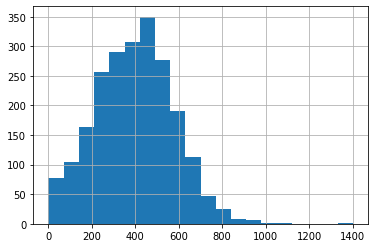

In [211]:
smart['spent_minutes'].hist(bins=20, range=(1, 1400))

Среднее значение и медиана длительности звонков отличаются всего на 4 минуты, а вот разброс/стандартное отклонение достаточно большое - более 183 минуты. 

Для того, чтобы выяснить вероятность длительности звонков в пределах стандартного отклонения (как в меньшую, так и в большую сторону), применим метод st.norm.cdf().

In [212]:
sm_call_mean = smart['spent_minutes'].mean()
distr_smart = st.norm(sm_call_mean, dev_smart) 

x1_sm = sm_call_mean - dev_smart
x2_sm = sm_call_mean + dev_smart

prob_sm = distr_smart.cdf(x2_sm) - distr_smart.cdf(x1_sm)
print('Вероятность длительности звонков от {:.0f} минут до {:.0f} минут равна {:.0%}.'.format(x1_sm, x2_sm, prob_sm))

Вероятность длительности звонков от 217 минут до 575 минут равна 68%.


Судя по гистограмме, большинство пользователей тарифа "Смарт" не перерасходуют бесплатный лимит звонков.

Вероятность ~ 70% попадания в промежуток продолжительности разговоров от 200 до 600 минут наглядно представлена на графике.

Проанализируем как изменялась средняя продолжительность разговоров и среднее количество звонков в течении года.   

In [213]:
cal_mnth_sm = smart.groupby('month')['spent_minutes'].mean()
print(cal_mnth_sm)

cal_qty_sm = smart.groupby('month')['quantity'].sum()
print(cal_qty_sm)

users_sm = smart.groupby('month')['user_id'].count()
users_sm

month
1.0     193.500000
2.0     283.413793
3.0     368.337662
4.0     346.767857
5.0     365.709220
6.0     375.969325
7.0     386.004975
8.0     401.575107
9.0     406.575290
10.0    404.136519
11.0    412.406349
12.0    453.544643
Name: spent_minutes, dtype: float64
month
1.0       941.0
2.0      2331.0
3.0      4183.0
4.0      5747.0
5.0      7789.0
6.0      9110.0
7.0     11402.0
8.0     13856.0
9.0     15482.0
10.0    17629.0
11.0    19435.0
12.0    22406.0
Name: quantity, dtype: float64


month
1.0      34
2.0      58
3.0      77
4.0     112
5.0     141
6.0     163
7.0     201
8.0     233
9.0     259
10.0    293
11.0    315
12.0    336
Name: user_id, dtype: int64

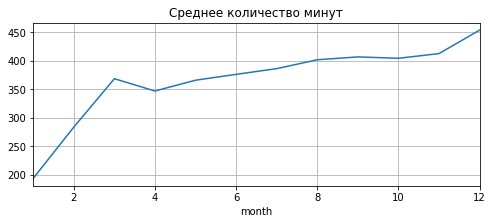

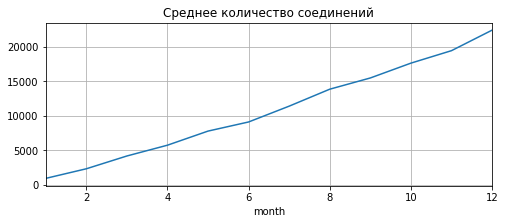

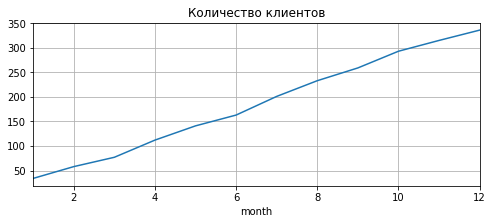

In [214]:
cal_mnth_sm.plot(grid=True, figsize=(8, 3), title='Среднее количество минут')
plt.show()

cal_qty_sm.plot(grid=True, figsize=(8, 3), title='Среднее количество соединений')
plt.show()

users_sm.plot(grid=True, figsize=(8, 3), title='Количество клиентов')

В течении 2018 года количество пользователей тарифа "Смарт" увеличилось почти на порядок (c 34 до 336), средняя продолжительность разговоров увеличилась в 2,3 раза (с 194 минут до 454), в то же время количество соединений увеличилось почти в 24 раза (с 941 в январе до 22406 звонков в декабре). 

Можно предположить, что клиенты меньше пользуются голосовой сотовой связью для длительных разговоров, предпочитая использовать для этой цели [голосовую возможность общения через мессенджеры](https://www.vedomosti.ru/technology/articles/2018/03/12/753235-svyaz-uhodit).

#### СМС



In [215]:
var_smart_sms = np.var(smart['messages'], ddof=1)
dev_smart_sms = np.sqrt(var_smart_sms)
print('Дисперсия равна:', var_smart_sms)
print('Стандартное отклонение равно:', dev_smart_sms)
smart['messages'].describe()

Дисперсия равна: 798.4826008264941
Стандартное отклонение равно: 28.257434434613735


count    2222.000000
mean       33.410891
std        28.257434
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

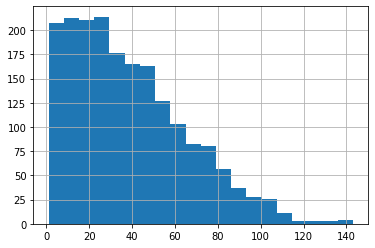

In [216]:
smart['messages'].hist(bins=20, range=(1, 143))

In [217]:
sm_sms_mean = smart['messages'].mean()
distr_smart_sms = st.norm(sm_sms_mean, dev_smart_sms) 

x1_sm_sms = sm_sms_mean - dev_smart_sms
x2_sm_sms = sm_sms_mean + dev_smart_sms

prob_sm_sms = distr_smart_sms.cdf(x2_sm_sms) - distr_smart_sms.cdf(x1_sm_sms)
print('Вероятность количества смс от {:.0f} до {:.0f} равна {:.0%}.'.format(x1_sm_sms, x2_sm_sms, prob_sm_sms))

Вероятность количества смс от 5 до 62 равна 68%.


month
1.0     18.235294
2.0     24.086207
3.0     31.857143
4.0     30.741071
5.0     33.773050
6.0     33.312883
7.0     33.751244
8.0     33.849785
9.0     33.644788
10.0    33.808874
11.0    34.120635
12.0    35.997024
Name: messages, dtype: float64


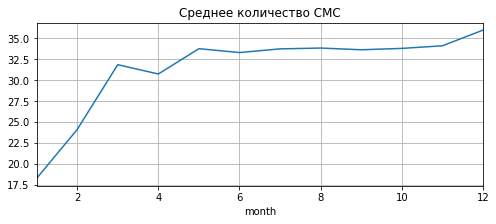

In [218]:
sms_mnth_sm = smart.groupby('month')['messages'].mean()
print(sms_mnth_sm)

sms_mnth_sm.plot(grid=True, figsize=(8, 3), title='Среднее количество СМС')

В течении 2018 года клиенты тарифа "Смарт" достаточно редко пользовались услугой СМС, в то же время, среднее количество СМС увеличилось с начала года в 2 раза (с 18 до 36). Большая часть пользователей тарифа укладываются во включённый пакет.

#### Интернет трафик

In [219]:
var_smart_int = np.var(smart['gb_used'], ddof=1)
dev_smart_int = np.sqrt(var_smart_int)
print('Дисперсия равна:', var_smart_int)
print('Стандартное отклонение равно:', dev_smart_int)
print('\n')
smart['gb_used'].describe()

Дисперсия равна: 32.98717888448007
Стандартное отклонение равно: 5.743446603258367




count    2222.000000
mean       16.337084
std         5.743447
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64

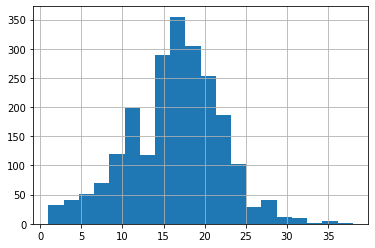

In [220]:
smart['gb_used'].hist(bins=20, range=(1, 38))

In [221]:
sm_int_mean = smart['gb_used'].mean()
distr_smart_int = st.norm(sm_int_mean, dev_smart_int) 

x1_sm_int = sm_int_mean - dev_smart_int
x2_sm_int = sm_int_mean + dev_smart_int

prob_sm_int = distr_smart_int.cdf(x2_sm_int) - distr_smart_int.cdf(x1_sm_int)
print('Вероятность использования интернет трафика в пределах от {:.0f}Гб до {:.0f}Гб равна {:.2%}.'.format(x1_sm_int, x2_sm_int, prob_sm_int))

Вероятность использования интернет трафика в пределах от 11Гб до 22Гб равна 68.27%.


month
1.0      8.735294
2.0     11.844828
3.0     15.233766
4.0     13.625000
5.0     15.907801
6.0     15.969325
7.0     15.875622
8.0     16.832618
9.0     16.389961
10.0    16.870307
11.0    16.996825
12.0    18.205357
Name: gb_used, dtype: float64


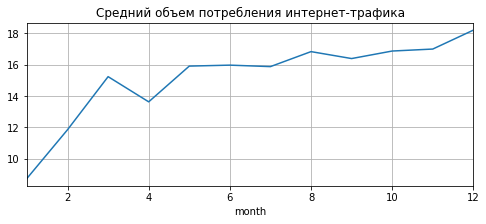

In [222]:
int_mnth_sm = smart.groupby('month')['gb_used'].mean()
print(int_mnth_sm)

int_mnth_sm.plot(grid=True, figsize=(8, 3), title='Средний объем потребления интернет-трафика')

В течении 2018 года клиенты тарифа "Смарт" активно пользовались интернетом, в среднем на 1-3Гб перерасходуя бесплатный лимит тарифа. Наблюдается постепенное увеличение потребления интернет-трафика.

### Тариф «Ультра»

#### Голосовой трафик

- Рассмотрим этот тариф по аналогии с тарифом "Смарт".

In [223]:
var_ultra = np.var(ultra['spent_minutes'], ddof=1)
dev_ultra = np.sqrt(var_ultra)
print('Дисперсия равна:', var_ultra)
print('Стандартное отклонение равно:', dev_ultra)
ultra['spent_minutes'].describe()

Дисперсия равна: 83821.49740203949
Стандартное отклонение равно: 289.5194249131472


count     941.000000
mean      518.601488
std       289.519425
min         0.000000
25%       297.000000
50%       502.000000
75%       717.000000
max      1579.000000
Name: spent_minutes, dtype: float64

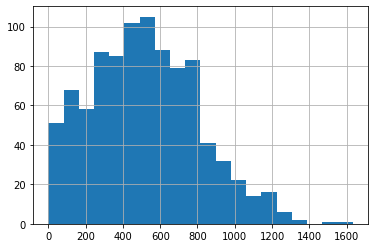

In [224]:
ultra['spent_minutes'].hist(bins=20, range=(0, 1632))

In [225]:
ul_call_mean = ultra['spent_minutes'].mean()
distr_ultra = st.norm(ul_call_mean, dev_ultra) 

x1_ul = ul_call_mean - dev_ultra
x2_ul = ul_call_mean + dev_ultra

prob_ul = distr_ultra.cdf(x2_ul) - distr_ultra.cdf(x1_ul)
print('Вероятность длительности звонков от {:.0f} минут до {:.0f} минут равна {:.0%}.'.format(x1_ul, x2_ul, prob_ul))

Вероятность длительности звонков от 229 минут до 808 минут равна 68%.


Интересно, что среднее значение голосового трафика больше, чем медианное (скошенность набора данных вправо). 68% пользователей тарифа используют от 229 до 808 минут, при среднем значении - 519 минуты. Никто не использует предоставленный пакет минут полностью. Максимум 1579 минут.

Проанализируем как изменялась средняя продолжительность разговоров и среднее количество звонков в течении года.

In [226]:
cal_mnth_ul = ultra.groupby('month')['spent_minutes'].mean()
print(cal_mnth_ul)

cal_qty_ul = ultra.groupby('month')['quantity'].sum()
print(cal_qty_ul)

users_ul = ultra.groupby('month')['user_id'].count()
users_ul

month
1.0     405.333333
2.0     298.454545
3.0     462.945946
4.0     448.679245
5.0     509.507937
6.0     473.425000
7.0     536.678161
8.0     503.794118
9.0     530.845455
10.0    551.820513
11.0    533.320312
12.0    583.526316
Name: spent_minutes, dtype: float64
month
1.0       535.0
2.0       972.0
3.0      2504.0
4.0      3525.0
5.0      4834.0
6.0      5566.0
7.0      6852.0
8.0      7575.0
9.0      8546.0
10.0     9477.0
11.0    10021.0
12.0    11540.0
Name: quantity, dtype: float64


month
1.0       9
2.0      22
3.0      37
4.0      53
5.0      63
6.0      80
7.0      87
8.0     102
9.0     110
10.0    117
11.0    128
12.0    133
Name: user_id, dtype: int64

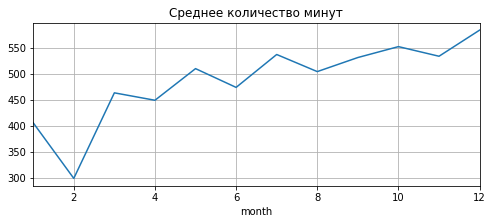

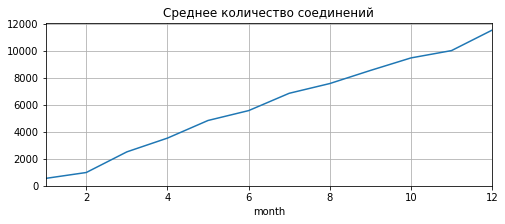

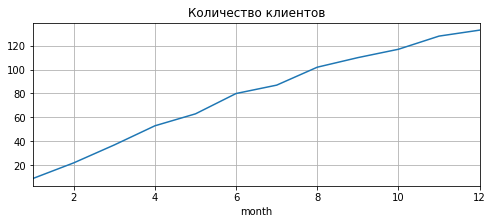

In [227]:
cal_mnth_ul.plot(grid=True, figsize=(8, 3), title='Среднее количество минут')
plt.show()

cal_qty_ul.plot(grid=True, figsize=(8, 3), title='Среднее количество соединений')
plt.show()

users_ul.plot(grid=True, figsize=(8, 3), title='Количество клиентов')

В течении 2018 года количество пользователей тарифа "Ультра" увеличилось почти в 15 раз (c 9 до 133), средняя продолжительность разговоров увеличилась в 1,4 раза (с 405 минут до 584), в то же время количество соединений увеличилось почти в 22 раза (с 535 в январе до 11540 звонков в декабре). 

Хотя количество пользователей этого тарифа в разы меньше, однако, тенденции схожи с тарифом "Смарт".

#### СМС



In [228]:
var_ultra_sms = np.var(ultra['messages'], ddof=1)
dev_ultra_sms = np.sqrt(var_ultra_sms)
print('Дисперсия равна:', var_ultra_sms)
print('Стандартное отклонение равно:', dev_ultra_sms)
ultra['messages'].describe()

Дисперсия равна: 2215.2246930607994
Стандартное отклонение равно: 47.066173554483896


count    941.000000
mean      49.260361
std       47.066174
min        0.000000
25%        5.000000
50%       40.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

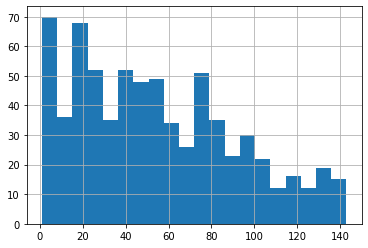

In [229]:
ultra['messages'].hist(bins=20, range=(1, 143))


month
1.0     33.777778
2.0     23.727273
3.0     32.297297
4.0     32.584906
5.0     38.126984
6.0     40.075000
7.0     48.609195
8.0     47.931373
9.0     51.990909
10.0    58.666667
11.0    56.210938
12.0    60.917293
Name: messages, dtype: float64


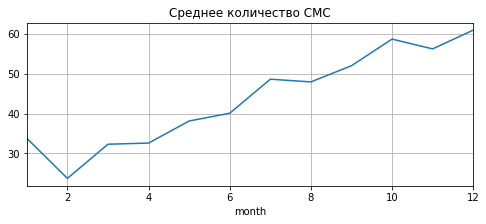

In [230]:
sms_mnth_ul = ultra.groupby('month')['messages'].mean()
print(sms_mnth_ul)

sms_mnth_ul.plot(grid=True, figsize=(8, 3), title='Среднее количество СМС')

Несмотря на то, что в пакет тарифа "Ультра" включено 1000 сообщений в месяц, пользователи достаточно редко отправляли СМС. В течении 2018 года среднее количество СМС увеличилось с начала года почти в 1,8 раза (с 34 до 61). Предположу, что чаще используют мессенджеры, чем (даже включенные в тариф) СМС.

#### Интернет трафик

In [231]:
var_ultra_int = np.var(ultra['gb_used'], ddof=1)
dev_ultra_int = np.sqrt(var_ultra_int)
print('Дисперсия равна:', var_ultra_int)
print('Стандартное отклонение равно:', dev_ultra_int)
print('\n')
ultra['gb_used'].describe()

Дисперсия равна: 94.77815587763132
Стандартное отклонение равно: 9.735407329826078




count    941.000000
mean      19.695005
std        9.735407
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64

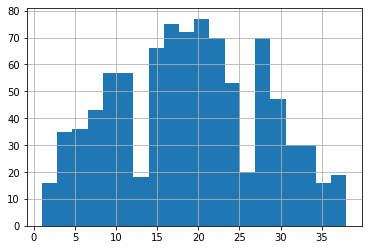

In [232]:
ultra['gb_used'].hist(bins=20, range=(1, 38))

In [233]:
ul_int_mean = ultra['gb_used'].mean()
distr_ultra_int = st.norm(ul_int_mean, dev_ultra_int) 

x1_ul_int = ul_int_mean - dev_ultra_int
x2_ul_int = ul_int_mean + dev_ultra_int

prob_ul_int = distr_ultra_int.cdf(x2_ul_int) - distr_ultra_int.cdf(x1_ul_int)
print('Вероятность использования интернет трафика в пределах от {:.0f}Гб до {:.0f}Гб равна {:.2%}.'.format(x1_ul_int, x2_ul_int, prob_ul_int))

Вероятность использования интернет трафика в пределах от 10Гб до 29Гб равна 68.27%.


month
1.0     13.222222
2.0     13.090909
3.0     17.648649
4.0     17.528302
5.0     19.984127
6.0     19.162500
7.0     20.678161
8.0     19.803922
9.0     19.309091
10.0    20.264957
11.0    19.820312
12.0    21.812030
Name: gb_used, dtype: float64


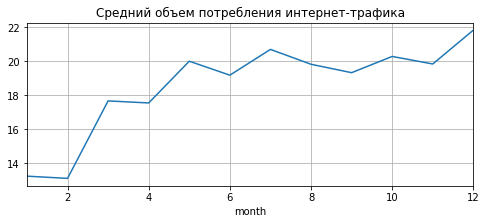

In [234]:
int_mnth_ul = ultra.groupby('month')['gb_used'].mean()
print(int_mnth_ul)

int_mnth_ul.plot(grid=True, figsize=(8, 3), title='Средний объем потребления интернет-трафика')

Большая часть пользователей тарифа "Ультра" укладываются в отведённый лимит трафика в 30Гб. 

В течении 2018 года наблюдается постепенное увеличение потребления интернет-трафика (с 13 до 22Гб).

### Визуально сравним тарифы

* ####  По количеству пользователей

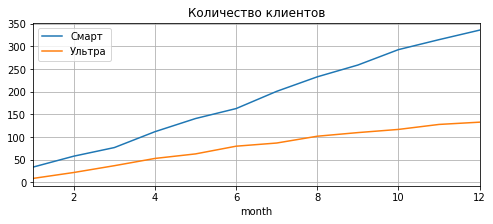

In [235]:
users_sm.plot(grid=True, figsize=(8, 3), title='Количество клиентов')
users_ul.plot(grid=True, figsize=(8, 3), title='Количество клиентов')

plt.legend(labels= ['Смарт', 'Ультра'])

* ####  По ежемесячному голосовому трафику

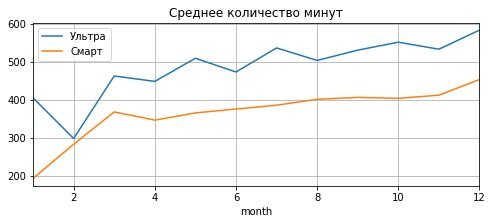

In [236]:
cal_mnth_ul.plot(grid=True, figsize=(8, 3), title='Среднее количество минут')
cal_mnth_sm.plot(grid=True, figsize=(8, 3), title='Среднее количество минут')

plt.legend(labels= ['Ультра', 'Смарт'])

* ####  По количеству отправленных СМС

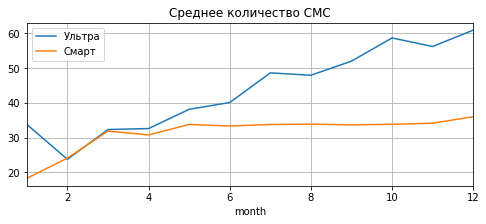

In [237]:
sms_mnth_ul.plot(grid=True, figsize=(8, 3), title='Среднее количество СМС')
sms_mnth_sm.plot(grid=True, figsize=(8, 3), title='Среднее количество СМС')

plt.legend(labels= ['Ультра', 'Смарт'])

* ####  По ежемесячному интернет-трафику

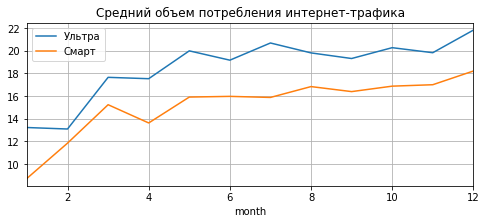

In [238]:
int_mnth_ul.plot(grid=True, figsize=(8, 3), title='Средний объем потребления интернет-трафика')
int_mnth_sm.plot(grid=True, figsize=(8, 3), title='Средний объем потребления интернет-трафика')

plt.legend(labels= ['Ультра', 'Смарт'])

### Шаг 4. Проверка гипотез

- #### Средняя выручка пользователей тарифов «Смарт» и «Ультра» различается.


В нашем случае есть 2 генеральных совокупности - выручка пользователей тарифа «Смарт» и «Ультра».
Чтобы проверить гипотезу, различается ли средняя выручка от этих тарифов, применим метод scipy.stats.ttest_ind().
За нулевую гипотезу примем, что выручка НЕ различается (ровна). Альтернативная гипотеза - тарифы приносят разную выручку. Границу нулевой гипотезы определим в 5%.

In [239]:
smart_rev_mean = smart['revenue'].mean()
print('Средняя выручка с тарифа "Смарт":', round(smart_rev_mean))

ultra_rev_mean = ultra['revenue'].mean()
print('Средняя выручка с тарифа "Ультра":', round(ultra_rev_mean))

print('\n')

smart_rev = smart['revenue']
ultra_rev = ultra['revenue']

alpha = .05

res_rev_dif = st.ttest_ind(ultra_rev, smart_rev) 
    
print('p-значение:', res_rev_dif.pvalue)

if (res_rev_dif.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка с тарифа "Смарт": 1259.0
Средняя выручка с тарифа "Ультра": 2072.0


p-значение: 1.5154324906198753e-171
Отвергаем нулевую гипотезу


Итак, мы отвергли нулевую гипотезу. Дополнительным подтверждением различия выручки от этих тарифов может служить достаточно большая разница между средними значениями по этим тарифам - более 62%.

- #### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Объединим тарифные датафреймы с необходимой информацией (столбцы `user_id, city, revenue`). Затем выделим отдельно выручку Московских пользователей и региональных. 

In [240]:
smart_users = smart[['user_id', 'city', 'revenue']]
smart_users

ultra_users = ultra[['user_id', 'city', 'revenue']]
ultra_users

merge_tariffs = [smart_users, ultra_users]
merged = reduce(lambda left,right: pd.merge(left,right, how='outer'), merge_tariffs)

select_mos = merged.query('city == "Москва"')[['user_id','revenue']]
select_mos_sample = select_mos['revenue']

select_regions = merged.query('city != "Москва"')[['user_id','revenue']]
select_regions_sample = select_regions['revenue']

print('Средняя выручка Московских пользователей:', round(select_mos_sample.mean()))
print('Средняя выручка региональных пользователей:', round(select_regions_sample.mean()))

Средняя выручка Московских пользователей: 1526.0
Средняя выручка региональных пользователей: 1495.0


Чтобы проверить гипотезу о равенстве средней выручки двух генеральных совокупностей (выручка Московских и региональных пользователей) по соответствующим выборкам, применим метод scipy.stats.ttest_ind().

Сформулируем гипотезу:
- H0 - выручка пользователей из Москвы не отличается от выручки пользователей из регионов;
- Н1 - выручка пользователей из Москвы отличается от выручки пользователей из регионов.

In [241]:
alpha = .05 

result_mos = st.ttest_ind(select_mos_sample, select_regions_sample)

print('p-значение:', result_mos.pvalue)

if (result_mos.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3805567054666693
Не получилось отвергнуть нулевую гипотезу


p-value оказалось больше порогового, соответственно, гипотеза о том, что выручка Московских пользователей не отличается от выручки региональных пользователей принимается.

### Шаг 5. Общий вывод

В середине 2000-х гг. доходы российских операторов от их традиционных услуг вроде телефонных звонков или отправки sms ежегодно росли более чем на 30%. Но после кризиса 2008–2009 гг. рост сначала резко замедлился, а с 2014 г. прекратился и даже стал показывать отрицательную динамику, [следует из данных AC&M Consulting]( https://www.vedomosti.ru/technology/articles/2018/03/21/754381-sotovie-operatori-istochniki).

Традиционные услуги связи становятся все менее востребованными и наше исследование тому подтверждение:
1)	Большинство пользователей тарифа «Смарт» укладываются в отведённый пакетом лимит по звонкам и даже пользователи тарифа «Ультра» в среднем используют не более 600 мин (на конец 2018г.), не смотря на предоставленные пакетом 3000 мин.
2)	Пользователи обоих пакетов в большинстве случаев не используют предоставленный лимит по отправке текстовых сообщений.

В то же время, интернет-трафик используется активно в обоих тарифах. 
- Пользователям "Смарт" в среднем не хватает (1 - 3Гб) пакетного лимита (15Гб). Но при этом, переходить на "Ультра" им нет смысла, т.к. даже с перерасходом трафика на 3Гб пакет "Смарт" для них выгоднее (1150 руб.). Задуматься о переходе на тариф "Ультра" имеет смысл, если пользователь тарифа "Смарт" расходует более 21Гб интернет_трафика в месяц. 
- Большинство пользователей тарифа "Ультра" не используют полностью предоставленный пакетный интернет (30Гб). Однако, средний трафик декабря (22Гб) говорит о том, что в большинстве случаев, пользователям тарифа "Ультра" не выгодно переходить на "Смарт".   

Отвечая на основной вопрос этого исследования, можно с уверенностью сказать, что тариф «Ультра» приносит больше выручки из расчета на одного пользователя. Однако, (если предположить, что наша выборка отражает общую картину клиентской базы оператора) принимая во внимание, что пользователей тарифа «Смарт» в 2.5 раза больше, а средняя величина выручки с одного клиента меньше в 1.6 раза, можно утверждать, что валовая выручка больше у тарифа «Смарт».
